<a href="https://colab.research.google.com/github/AvantiShri/gcp_analysis_rough/blob/main/GCP1_attempt_rep_pbancel_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Preparation

In [2]:
#mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/GCP_data/all_data
#data at https://drive.google.com/drive/u/0/folders/1MUS-xbwoBiodWLz4gese19ti_ftlKsVu

/content/drive/MyDrive/GCP_data/all_data


In [4]:
#install utilities code for reading/parsing data at https://github.com/AvantiShri/gcpdatautils
!pip uninstall -y gcpdatautils #uninstall the pre-existing version if want to fetch latest
!pip install git+https://github.com/AvantiShri/gcpdatautils.git@main #install latest from github

#Note: the code that was used to consolidate the downloaded csv.gz files into hdf5 files
# is at https://github.com/AvantiShri/gcp_analysis/blob/main/alldata/Consolidate_GCP_as_HDF5.ipynb

  Cloning https://github.com/AvantiShri/gcpdatautils.git (to revision main) to /tmp/pip-req-build-ng2vrrpy
  Running command git clone --filter=blob:none --quiet https://github.com/AvantiShri/gcpdatautils.git /tmp/pip-req-build-ng2vrrpy
  Resolved https://github.com/AvantiShri/gcpdatautils.git to commit 55a9bc16c7c36ea920eafb44079d401f76da48f1
  Preparing metadata (setup.py) ... done
  Created wheel for gcpdatautils: filename=gcpdatautils-0.1.1.3-py3-none-any.whl size=6405 sha256=308b4b79e59f3d6bf81c5624b8189b4505df451f36201632537c79876f4fac9b
  Stored in directory: /tmp/pip-ephem-wheel-cache-9g3d36y2/wheels/8c/35/d9/946037b24577e21d0dce0d66645d002768f5bac3497186d55f
Successfully built gcpdatautils


Load in the GCP event timeperiod definitions

In [8]:
from gcpdatautils import parse_events_html

#download the formal event registry if not already present
!wget https://global-mind.org/pred_formal.html -O pred_formal.html

# we will parse the events file, dropping events longer than 30 days for memory efficiency
# we will also drop 'New Year Var...' events as they tend to be redundant in duration
# with the 'mean' events, and we are going to do a standard analysis on all the events
included_events = parse_events_html("/content/drive/MyDrive/GCP_data/pred_formal.html",
                                    exclude_events_longer_than_days=30)

--2024-02-13 19:54:25--  https://global-mind.org/pred_formal.html
Resolving global-mind.org (global-mind.org)... 162.245.217.130
Connecting to global-mind.org (global-mind.org)|162.245.217.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘pred_formal.html’

pred_formal.html        [ <=>                ] 184.64K  1.13MB/s    in 0.2s    

2024-02-13 19:54:25 (1.13 MB/s) - ‘pred_formal.html’ saved [189067]

Skipping because redundant with a corresponding 'mean' event:  43 New Year Var 99-00 1999-12-31 09:30:00 2000-01-01 11:29:59
Skipping because redundant with a corresponding 'mean' event:  65 New Year Var 00-01 2000-12-31 09:30:00 2001-01-01 11:29:59
Skipping because end < start: 82 Silent Prayer, Sept 14 2001-09-14 10:00:00 2001-09-14 10:00:00
Skipping because redundant with a corresponding 'mean' event:  98 New Year Var 01-02 2001-12-31 09:30:00 2002-01-01 11:29:59
Skipping because redundant with a corresponding 'mean' ev

In [9]:
len(included_events)

480

Load the code for reading from the hdf5 files

In [10]:
import numpy as np
from collections import defaultdict
import h5py
from datetime import datetime, timedelta
from gcpdatautils import GCPHdf5DataReader, GCPMissingDataError

#Refer to the github repo https://github.com/AvantiShri/gcpdatautils for the
# code for reading from the hdf5 files
#Instantiate the hdf5 data reader
#it will auto-load a rotteneggs.txt file specifying bad data time periods (downloaded from https://global-mind.org/rotteneggs and saved in the package)
# this rotten egg file can be overridden by altering the arguments to the GCPHdf5DataReader
gcp_data_reader = GCPHdf5DataReader()

Parsing the bad data file: /usr/local/lib/python3.10/dist-packages/gcpdatautils/resources/rotteneggs.txt
manually correcting 47,2000-01-01 00:00:00,2001-06-31 23:59:59,2222
manually correcting 47,2008-04-25 00:00:00,2008-04-55 23:59:59,1092


Pull data for a specific event to compare to the GCP plots, as a sanity check

('289', 'Meditations Valentines Day', datetime.datetime(2009, 2, 14, 0, 0), datetime.datetime(2009, 2, 14, 23, 59, 59), 86400.0)


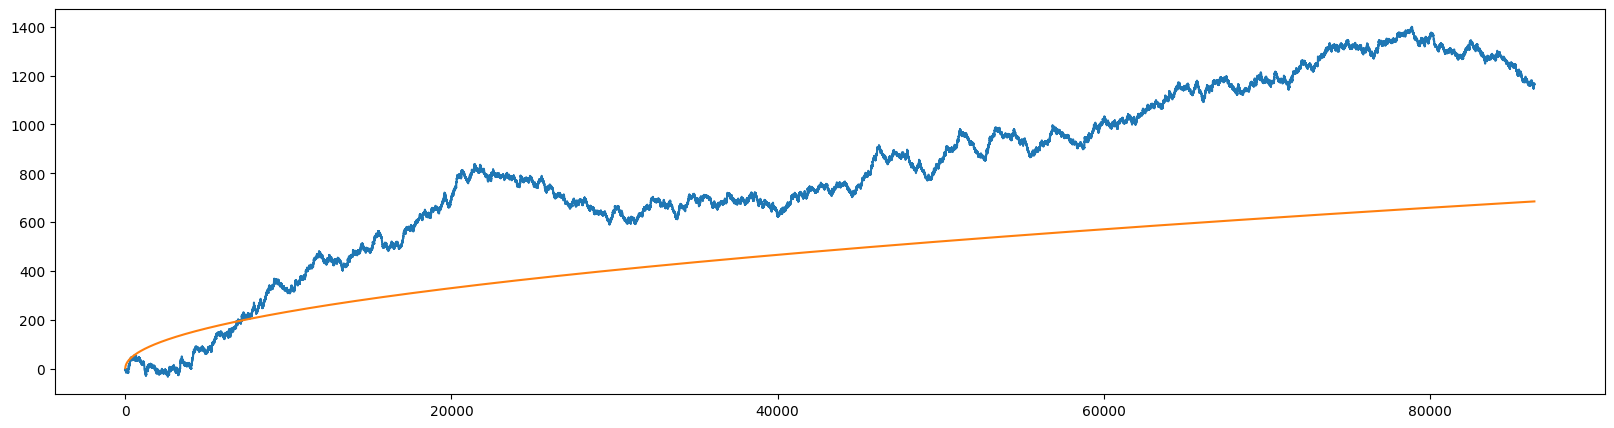

In [17]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import scipy
#data for a top-ranked GCP event - Valentine's day 2009
# Compare to: https://global-mind.org/valentines.09.html
idx=263
print(included_events[idx])

start_datetime, end_datetime = included_events[idx][2], included_events[idx][3]
event_data = gcp_data_reader.fetch_data(start_datetime, end_datetime, normalize=False)[0] #returns both the event data and the device ids; we just want the data

#make the chi-squared-minus-1 plot
csm1 = np.square(np.nansum((event_data - 100)/np.sqrt(50), axis=1)/np.sqrt(
        np.sum(np.isnan(event_data)==False, axis=1))) - 1
plt.figure(figsize=(20,5))
plt.plot(np.arange(len(csm1)), np.cumsum(csm1))
#also plot the p=0.05 envelop
plt.plot(np.arange(len(csm1)), np.array([scipy.stats.chi2.ppf(0.95, x+1)
                                         for x in np.arange(len(csm1))])
                                        - (np.arange(len(csm1))+1) )
plt.show()

Load the empirical variances, computed from https://github.com/AvantiShri/gcp_analysis/blob/main/alldata/ComputeLifetimeDeviceStats.ipynb

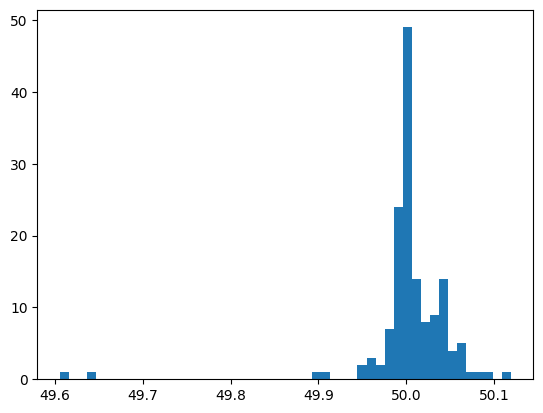

In [18]:
import json
from matplotlib import pyplot as plt

device_to_empirical_variances = json.loads(open("empirical_device_variances.json").read())
plt.hist(device_to_empirical_variances.values(), bins=50)
plt.show()

Do aggregate analysis

In [37]:
from datetime import datetime,timedelta
import numpy as np
import h5py
import traceback
import scipy


def normalize_by_lifetime_device_variance(data, devices, device_to_empirical_variances):
  data = np.array(data) #make a copy, just in case
  for i,device in enumerate(devices):
    scalefactor = (np.sqrt(device_to_empirical_variances[str(int(device))])/np.sqrt(50))
    data[:,i] = ((data[:,i]-100)/scalefactor)+100
  return data


def compute_composite_z(egg_values):

  num_nonnan_eggs = np.sum(np.isnan(egg_values)==False, axis=1) #get the number of non NaN eggs per row
  egg_zscores = (egg_values - 100)/np.sqrt(50)
  composite_z_scores = np.nansum(egg_zscores, axis=1)/np.sqrt(num_nonnan_eggs)

  return composite_z_scores


def get_normalized_data(start_datetime, end_datetime, device_to_empirical_variances):
  data, devices = gcp_data_reader.fetch_data(start_datetime, end_datetime, normalize=DAY_NORMALIZE)
  if LIFETIME_NORMALIZE:
    data = normalize_by_lifetime_device_variance(data, devices, device_to_empirical_variances)
  return data


DAY_NORMALIZE = False
LIFETIME_NORMALIZE = False
assert (DAY_NORMALIZE and LIFETIME_NORMALIZE)==False #at most one should be true

surviving_events = [] #in case we encounter missing data errors, maintain a list of surviving events

eventcount = 0

allevents_compositez = []
alltimeperiodbefore_compositez = []
alltimeperiodafter_compositez = []

missing_data_errors = []

flankfrac = 1.0

for (event_num, event_name, start_datetime, end_datetime, duration) in included_events[:]:
  eventcount += 1
  print("EVENT COUNT", eventcount)
  print(event_num, event_name, start_datetime, end_datetime, duration)
  try:
    event_data = get_normalized_data(start_datetime, end_datetime, device_to_empirical_variances)
    event_compositez = compute_composite_z(event_data)
    allevents_compositez.append(event_compositez)

    before_starttime = start_datetime - timedelta(seconds=int(duration*flankfrac) + 1)
    before_endtime = start_datetime - timedelta(seconds=1)
    before_data = get_normalized_data(before_starttime, before_endtime, device_to_empirical_variances)
    before_compositez = compute_composite_z(before_data)
    alltimeperiodbefore_compositez.append(before_compositez)

    after_starttime = end_datetime + timedelta(seconds=1)
    after_endtime = end_datetime + timedelta(seconds=int(duration*flankfrac) + 1)
    after_data = get_normalized_data(after_starttime, after_endtime, device_to_empirical_variances)
    after_compositez = compute_composite_z(after_data)
    alltimeperiodafter_compositez.append(after_compositez)

    surviving_events.append((event_num, event_name, start_datetime, end_datetime, duration))
  except GCPMissingDataError as e:
    print("MISSING DATA ERROR!",e)
    missing_data_errors.append(e)


EVENT COUNT 1
1 Embassy 1998-08-07 07:15:00 1998-08-07 10:14:59 10800.0
EVENT COUNT 2
3 Bomb Afghanistan 1998-08-20 17:15:00 1998-08-20 17:44:59 1800.0
EVENT COUNT 3
4 Swissair 111 Crash 1998-09-03 01:00:00 1998-09-03 03:59:59 10800.0
EVENT COUNT 4
5 McGwire Record 1998-09-09 01:00:00 1998-09-09 01:29:59 1800.0
EVENT COUNT 5
6 Clinton Grand Jury 1998-09-11 19:00:00 1998-09-11 22:59:59 14400.0
EVENT COUNT 6
7 Casitas Collapse 1998-10-30 15:30:00 1998-10-30 15:59:59 1800.0
EVENT COUNT 7
8 Casitas Flood 1998-10-30 19:00:00 1998-10-30 21:59:59 10800.0
EVENT COUNT 8
9 Global Vigil JT 1998-11-13 16:00:00 1998-11-13 16:14:59 900.0
EVENT COUNT 9
11 World Peace UN 1998-12-10 23:30:00 1998-12-11 00:29:59 3600.0
Before masking, fraction of nans in raw data is 0.14285714285714285 for 1998-12-10 23:30:00 to 1998-12-10 23:59:59
Found 'rotten egg' entries for device id: 1005 in time range 1998-12-10 23:30:00 to 1998-12-10 23:59:59 (range: 1998-12-10 00:00:00 to 1998-12-17 23:59:59 )
After masking, fr

The before and after plot using all events...

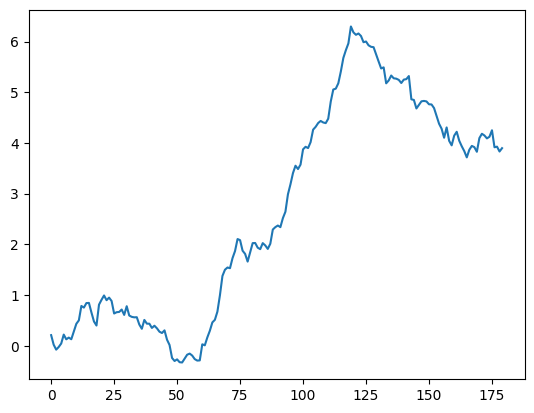

In [45]:
def resize_arr(arr, target_size): #will resize by chunking and averaging in chunks
  trimmed_arr = arr[0:len(arr)-(len(arr)%target_size)] #trim non-divisible end
  chunk_size = int(len(trimmed_arr)/target_size)
  resize_arr = np.sum(trimmed_arr.reshape((target_size,chunk_size)), axis=-1)/np.sqrt(chunk_size)
  return resize_arr

#the values supplied to resize_arr are the chi-squared-minus-1 values standardized to have a variance of 1
resize_allevents_chisqz = np.array([
    resize_arr((np.square(np.concatenate([x,y,z]))-1)/np.sqrt(2), target_size=180)
    for x,y,z in zip(alltimeperiodbefore_compositez, allevents_compositez, alltimeperiodafter_compositez) ])

plt.plot(np.cumsum(np.sum(resize_allevents_chisqz[:,:], axis=0)/
                   np.sqrt(resize_allevents_chisqz.shape[0]))/np.sqrt(60) )

An attempt at designating events with flexible start/end times...

In [47]:
events_with_flex_start_end = set([x[0] for x in [
 ('1', 'Embassy'),
 ('3', 'Bomb Afghanistan'),
 ('4', 'Swissair 111 Crash'),
 ('5', 'McGwire Record'),
 ('6', 'Clinton Grand Jury'),
 ('7', 'Casitas Collapse'),
 ('8', 'Casitas Flood'),
# ('9', 'Global Vigil JT'), #?
# ('11', 'World Peace UN'),
 ('12', 'Iraq Bombing'),
 ('13', 'Vote Impeachment'),
 #('14', 'Christmas Eve UTC'),
 #('15', 'Christmas Eve EST'),
 #('16', 'Christmas Eve PST'),
 #('17', 'New Year Mean 1998-1999'),
 ('21', 'Earthquake Columbia'),
 ('22', 'Clinton Acquittal'),
 ('23', 'Bomb Yugoslavia'),
 ('24', 'Dow Tops 10000'),
# ('25', 'Pray for Peace'),
 ('26', 'Littleton School'),
 ('27', 'Autonomy PLO'),
 ('28', 'Peace at Last'),
 ('29', 'War Ends Milosevic'),
 ('31', 'JFK Jr Crash'),
 ('32', 'India Train Crash'),
 ('35', 'Turkey Quake 4-hr'),
 ('36', 'Japan Nuclear Accident'),
# ('37', 'Billion Person Medit'),
 ('39', 'Typhoon India II'),
 ('40', 'Earthquake Turkey II'),
# ('41', 'Full Moon Solstice'),
# ('42', 'New Year Mean 1999-2000'),
# ('45', 'Just A Minute'),
 ('46', 'Papal Visit, Israel'),
 ('47', 'Great Experiment II'),
 #('48', 'World Earth Healing Day'),
 ('49', 'Concorde Crash, Paris'),
 ('50', 'Kursk Tragedy, 30-min'),
 ('51', 'Kursk, 10 days'),
 #('52', 'US TV: Survivors Finale'),
 ('53', 'Peace Summit Relig Spirit'),
 #('54', 'Olympic Opening Ceremony'),
 #('55', 'Group Mind Meditation'),
 ('56', 'Pierre Trudeau Funeral'),
 #('57', 'Group Mind Meditation 2'),
 ('58', 'US Election 2000, a'),
 #('59', 'Group Mind Meditation 3'),
 #('60', 'Group Mind Meditation 4'),
 #('61', 'Miss World 2000'),
 ('62', 'US Election 2000, b'),
 ('63', 'US Election 2000, Finality'),
 #('64', 'New Year Mean 2000-2001'),
 ('67', 'Central America Quake'),
 ('68', 'Bush Inauguration'),
 ('69', 'Kumbh Mela, India'),
 ('70', 'Western India Quake'),
 #('71', 'WorldPuja Webcast'),
 #('72', 'Johrei Ceremonies'),
 #('73', 'Earth Day, 2001'),
 #('74', 'Full Moon in Taurus'),
 #('75', 'World Peace Meditation'),
 #('76', 'World Earth Healing Day'),
 #('77', 'Roll Your Own Blackout'),
 ('78', 'Beijing Gets 2008 Olympics'),
# ('79', 'Buddhist Stupa Ceremony'),
 ('80', 'Terrorist Disaster, Sept 11'),
 ('82', 'Silent Prayer, Sept 14'),
 ('83', 'Sea to Shining See'),
 ('84', 'MUM Peace Meditation'),
 ('85', 'Begin Afghan Bombing'),
 ('86', 'Children Pledge Allegiance'),
 ('87', 'Binding Spell on Bin Laden'),
 ('88', 'Assassination in Israel'),
 #('89', 'World Series, Yankee Stadium'),
 #('90', 'World-Wide Meditations'),
 ('91', 'Crash of AA 587'),
 ('92', 'Ramadan Muslim Prayer'),
# ('93', 'World Puja Meditation'),
 ('94', 'George Harrison Tribute'),
 ('95', 'Sir Peter Blake Murder'),
 ('96', 'Astrological Moments'),
 #('97', 'New Year Mean 2001-2002'),
 ('99', 'Volcanic Eruption, Congo'),
 ('100', 'Astrid Lindgren Dies'),
# ('101', 'Winter Olympic Opening 02'),
 ('102', 'Sri Lanka Peace Meditation'),
 ('103', 'Earthquake Afghanistan'),
 ('104', 'Passover Bombing, Israel'),
 ('105', 'Jenin Incursion, Israel'),
 ('106', 'Tiger Woods Triumph'),
 ('107', 'Indigo Peace Meditation'),
 ('108', 'Erfurt School Shooting'),
# ('109', 'World Cup Soccer 2002'),
 ('110', 'Astrological Moments II'),
 ('111', 'Summer Solstice 2002'),
 ('112', 'World Cup Soccer 2002 II'),
 #('113', 'World Healing Day, 2002'),
 ('114', 'Etzold 9/11 Anniversary'),
 ('115', 'Mitchell 9/11 Anniversary'),
 ('117', "Korea's Birthday"),
 ('118', 'Bali Bombing'),
 ('119', 'Twyman in Baghdad'),
# ('120', 'Earthdance 2002'),
 ('121', 'Wellstone Plane Crash'),
 ('122', 'Chechen Hostage Tragedy'),
 ('123', 'Kenyan Terrorist Attacks'),
 ('124', 'Suicide Bombing in Grozny'),
 #('125', 'New Year Mean 2002-2003'),
 ('127', 'Tel Aviv Market Bombing'),
 ('128', 'Antiwar Protests, Jan 18 2003'),
 ('129', 'Shuttle Columbia Disaster'),
 ('130', 'Peace Meditation'),
# ('131', 'Global Peace Demonstrations'),
 ('132', 'Korean Subway'),
 ('133', 'Lysistrata'),
# ('134', 'Gather the Women'),
 ('135', 'Serbia Assassination'),
 ('136', 'Candlelight Vigil'),
 ('137', 'Begin War on Iraq -4 +4 hours'),
 ('138', 'Great Exp IV, Bush Prayer'),
 ('139', 'Iraq War Ends, Saddam Falls'),
 ('140', 'Suicide Bombing in Riyadh'),
 ('141', 'Suicide Bombing in Morroco'),
 ('142', 'Earthquake in Algeria'),
 ('143', 'Aqaba Summit, Middle East'),
 ('144', 'Rainbow, 4th July'),
 ('145', 'Love, Peace, Water Day'),
 ('146', 'Coup Attempt, Manila'),
 ('147', 'Blackout of 2003'),
 ('148', 'Bombing UN Baghdad'),
 ('149', 'Mars and Yang Spiral'),
 #('150', 'World Healing Day 2003'),
 ('151', '911 Anniversary'),
 ('152', 'Typhoon South Korea'),
 ('153', 'Dalai Lama, NYC'),
 ('154', 'Harmonic Concordance'),
 ('155', 'Turkey Synagogue Bombs'),
 ('156', 'Turkey Bank Consul'),
 ('157', 'Russia Commuter Train'),
 ('158', 'Saddam Captured'),
 ('159', 'Oprah Winfrey in Africa'),
 ('160', 'Earthquake in Bam, Iran'),
 ('161', '60 Seconds for Peace'),
 #('162', 'New Year Mean 2003-2004'),
 ('164', 'Hadj Ritual Tragedy'),
 ('165', 'Iran Train Explosion'),
# ('166', 'Oscar Ceremony 2004'),
 ('167', 'Attacks on Shiites, Iraq'),
 ('168', 'Terror Attacks in Madrid'),
 ('169', 'Demonstrations in Spain'),
 #('170', 'Global Day of Peace'),
 #('171', 'Cricket, India vs Pakistan'),
 ('172', 'Rantisi Assassination'),
 ('173', 'Korean Train Explosion'),
 ('174', 'Floods in Haiti'),
 ('175', 'Iraq Insurgency Bombs'),
 ('176', 'Turkish Train Wreck'),
 ('177', 'Democratic Convention, Kerry'),
 ('178', 'Fire in Paraguay'),
 ('179', 'Bob Morris Dies'),
 #('180', 'Olympic Opening Athens'),
 ('181', 'Day of Murderous Violence'),
 ('182', 'Republican Convention, Bush'),
 ('183', 'Russian School Hostage Crisis'),
 #('184', 'Earthdance 2004'),
 ('185', 'Intnl Day Peace + Hurricane Haiti'),
 ('186', 'Bombing in Taba, Egypt'),
 #('187', 'US Election 2004'),
 ('188', 'Arafat Dies'),
 ('189', 'Tsunami Indian Ocean'),
 #('190', 'New Year Mean 2004-2005'),
 ('192', 'Elections in Iraq'),
 ('193', 'Hariri Assassination Beirut'),
 ('194', 'Siyum Daf Yomi'),
 ('195', 'Quake, Indian Ocean'),
 ('196', 'Pope John Paul Dies'),
 ('197', "Pope Paul's Funeral"),
 ('198', "Prince Charles' Wedding"),
 #('199', 'Oraworld Resonance'),
 #('200', 'Live 8 Concert'),
 ('201', 'London Subway Bombs'),
 ('202', 'Hurricane Katrina'),
 ('203', 'Baghdad Bridge Stampede'),
 ('204', 'End the War Rally'),
 ('205', 'Bali Bombing 2'),
 ('206', 'Earthquake Pakistan'),
 ('207', 'India Train Crash'),
 ('208', 'India Bombs'),
 ('209', 'Jordan Bombs'),
# ('210', 'New Year Dev-Net Var'),
# ('211', 'New Year Covar Min'),
 ('212', 'Hadj Stoning 2006'),
 ('213', 'Mudslide, Philippines'),
 ('214', 'Golden Dome Bomb'),
 ('215', 'Planetary Play'),
 #('216', 'Earth Day, 2006'),
 ('217', 'Indonesian Earthquake'),
 ('218', 'Zarkawi News Release'),
 ('219', 'Bombay Train Bombings'),
 ('220', 'Avebury Meditations'),
 ('221', 'Qana Lebanon'),
 ('222', 'British Terror Plot'),
 ('224', 'Oraworld Reconciliation'),
 ('225', 'Native American Earth Ceremony'),
 ('226', 'Election 2006 Results'),
 ('227', 'Gemayel Assassination'),
 ('228', 'Global Deeksha'),
 ('229', 'Global Orgasm'),
 ('230', "Saddam's Execution"),
 #('231', 'New Year Mean 2006-2007'),
 ('233', 'European Storms'),
 ('234', 'Iraq Worst Bombing'),
 ('235', 'World Sound Healing'),
 ('236', 'India Train Fire'),
 ('237', 'Earth Hour'),
 ('238', 'Solomon Islands Quake'),
 ('239', 'Massacre at Virginia Tech'),
 ('240', 'Tai Chi Chigong Day'),
 ('241', 'World Meditation Aggregation'),
 ('242', 'Lightning Strikes Giuliani'),
 ('243', 'Palestinian Government Falls'),
 ('244', 'Live Earth'),
 ('245', 'Fire The Grid'),
 ('246', 'Minneapolis Bridge Collapse'),
 ('247', 'Peru Earthquake'),
 ('248', 'Burning Man'),
 ('249', 'Global OM'),
 #('250', 'International Day of Peace'),
 ('251', 'Gore wins Nobel'),
 ('252', 'Bomb Bhutto Homecoming'),
 ('253', 'Bangladesh Hurricane'),
 ('254', 'Algerian Car Bombs'),
 ('255', 'Benazir Bhutto Assassination'),
 #('256', 'New Year Mean, 2008'),
 ('258', 'Kandahar Bombs'),
 ('259', 'Attacks in Gaza'),
 ('260', 'Demonstrations in Tibet'),
 #('261', 'Earth Day, 2008'),
 ('262', 'Cyclone in Myanmar'),
# ('263', 'World Laughter Day'),
 ('264', 'Earthquake in China'),
 ('265', 'Silence, China Quake'),
 ('266', 'Obama Wins Nomination'),
 ('267', 'Kabul Car Bombing'),
 ('268', 'Olympic Opening Beijing'),
 ('269', 'War ends in Georgia'),
 #('270', 'World Meditation 080816'),
 #('271', 'Obama Acceptance 080828'),
 #('272', 'Palin Acceptance 080903'),
 #('273', 'McCain Acceptance 080904'),
 #('274', 'Peace Intention Experiment'),
 ('275', 'Islamabad Hotel Bombing'),
 #('276', 'International Day of Peace'),
 ('277', 'Bailout Vote Fails'),
 ('278', 'Temple Stampede Jodhpur'),
 ('279', 'Phillies Win World Series'),
 #('280', 'US Election 2008'),
 ('281', 'Mumbai Terror Attacks'),
 #('282', 'Global Orgasm III'),
 #('283', 'New Year Mean 2009'),
 ('285', 'Gaza Incursion'),
 ('286', 'Miracle on the Hudson'),
 ('287', 'Barack Obama Inauguration'),
 ('288', 'Australian Bush Fires'),
 ('289', 'Meditations Valentines Day'),
 ('290', 'Winnenden School Shooting'),
 ('291', 'G20 News Conference'),
 ('292', 'Binghamton Killings'),
 ('293', 'Italian Quake'),
 #('294', 'Earth Day, 2009'),
 ('295', 'Swine Flu Peak'),
 ('296', 'Indian Elections 2009'),
 ('297', 'Air France Disappearance'),
 ('298', 'Iran Unrest'),
 ('299', 'Live H2O event'),
 ('300', 'Michael Jackson Dies'),
 ('301', 'Michael Jackson Memorial'),
 ('302', 'Wansdyke Path II'),
 ('303', 'Fire the Grid II'),
 ('304', 'Typhoon Hits Taiwan'),
 ('305', 'Ted Kennedy Dies'),
 ('306', 'Earthquake in Java'),
 #('307', 'International Peace Day'),
 ('308', 'Tsunami in Samoa'),
 ('309', 'Earthquake, Padang Indonesia'),
 ('310', 'Obama Wins Nobel Peace Prize'),
# ('311', 'Climate Action 350'),
 ('312', 'Baghdad Bombs'),
 ('313', 'Fort Hood Massacre'),
 ('314', 'Haj Arafat Vigil'),
 ('315', 'Haj Stoning'),
 ('316', 'Bomb Attempt Dec 25'),
 #('317', 'New Year Mean 2010'),
 ('319', 'Pakistan Volleyball Bombing'),
 ('320', 'Haiti Earthquake'),
# ('321', 'State of the Union'),
# ('322', 'Olympic Opening Vancouver'),
 ('323', 'Chile Earthquake Tsunami'),
 ('324', 'Health Care is Law'),
 ('325', 'Moscow Train Bombing'),
 ('326', 'Mine Disaster, W. Va'),
 ('327', 'Mudslides in Brazil'),
 ('328', 'Polish President Dies'),
 ('329', 'Kumbh Mela, India'),
 ('330', 'Earthquake West China'),
 #('331', 'Earth Day, 2010'),
 ('332', 'Russian Coal Mine'),
# ('333', 'World Shift Day'),
 ('334', 'Lahore Religious Terror'),
 ('335', 'Israel Attacks Flotilla'),
 #('336', 'World Cup 2010 Begins'),
 #('337', 'World Cup 2010 Final'),
 #('338', 'Conscious Convergence'), #?
 ('339', 'Love Parade Tragedy'),
 ('340', 'Pakistani Flooding'),
 ('341', 'Chilean Miners Alive'),
 ('342', 'Ending Iraq War'),
 ('343', 'Billion Beats'),
 #('344', 'Earthdance 2010'),
 ('345', 'Astrological Moment III.1'),
 #('346', 'International Day of Peace'),
 #('347', 'World Day of Interconnection'),
 ('348', 'World Forum, Kazakhstan'),
 ('349', 'Indonesia, Quake, Volcano'),
 ('350', 'Election 2010 Results'),
 ('351', 'New Reality, 11 days'),
 ('352', 'Cambodia Bridge Tragedy'),
 ('353', 'North South Korea Shelling'),
 ('354', 'Wikileaks Diplomatic Trove'),
 ('355', 'Goodearth Halleluia'),
 #('356', 'New Year Mean 2011'),
 ('358', 'Egypt Christian Attack'),
 ('359', 'Congresswoman Giffords'),
 ('360', 'Brazilian Mudslides'),
 ('361', 'Tucson Memorial'),
 ('362', 'Moscow Airport Bombing'),
# ('363', 'State of the Union'),
 ('364', 'Egypt Day of Rage'),
 ('365', 'Egypt Continuing Protests'),
 ('366', 'Egypt Mubarak Resigns'),
 ('367', 'Earthquake, Christchurch NZ'),
 ('368', 'Turmoil in Libya'),
# ('369', "Women's Day 100th"),
# ('370', 'Breathe as One'),
 ('371', 'Tsunami, Japan'),
 ('372', 'Middle East Turmoil'),
 ('373', 'Water Prayer'),
# ('374', 'Earth Day, 2011'),
 ('375', 'Sai Baba Dies'),
 ('376', 'William &amp Catherine'),
 ('377', 'Pope Paul Beatification'),
 ('378', 'Osama Bin Laden Killed'),
 ('379', 'Tornadoes in Missouri'),
 ('380', 'Atlantis Last Launch'),
# ('381', 'Womens World Cup'),
 ('382', 'Oslo Bombing'),
 ('383', 'China Train Crash'),
 ('384', 'Downgrade & Helicopter Crash'),
 ('385', 'UK Rioting'),
 ('386', 'Rain in Tunisia'),
 ('387', 'Libya Rebel Day 1'),
 ('388', 'Earthquake East Coast'),
 ('389', 'Irene Landfall'),
 ('390', 'Anniversary 911 2001'),
# ('391', 'Internat Day Peace'),
 ('393', 'Wall Street Protests'),
 ('394', 'Bombing, Mogadishu'),
 ('395', 'Steve Jobs Dies'),
 ('396', 'Thailand and Greece'),
 ('397', 'Gaddafi Killed'),
 ('398', 'Turkey Quake 7.2'),
# ('399', '11-11-11 Meditations'),
 ('400', 'Kabul Shiite Bombing'),
 ('401', 'Gunman in Liege'),
 ('402', 'Philippine Floods'),
 ('403', 'Kim Jong-Il Dies'),
# ('404', 'New Year Mean 2012'),
 ('406', 'Cruise Ship Disaster'),
 ('407', 'SOPA Protests, Withdrawal'),
# ('408', 'State of the Union'),
 ('409', 'Syrian Tragedy'),
 ('410', 'Honduran Prison'),
# ('411', 'Do As One Day'),
 ('412', 'Oakland School Shooting'),
 ('413', 'Mogadishu Bombing'),
 ('414', 'Avalanch Pakistan'),
 ('415', 'Ferry Bengal'),
# ('416', 'Climate Impact'), #?
 ('417', 'Damascus Bombing'),
 ('418', 'Massacre Syria'),
 ('419', 'Obamacare SCOTUS'),
 ('420', 'Mexico Elections'),
 ('421', 'Massacre Tremseh'),
 ('422', 'Batman Shooting'),
# ('423', 'Olmympic Opening'),
 ('424', 'Sikh Shootings'),
# ('425', 'Romney Acceptance'),
# ('426', 'Burning Man 2012'),
 ('427', 'Obama Acceptance'),
 ('428', 'Karachi Factory Fire'),
# ('429', 'Internat Day Peace'),
 ('430', 'Hurricane Sandy'),
 ('431', 'Obama Elected 2012'),
 ('432', 'Palestine UN Vote'),
 ('433', 'Philippines Typhoon'),
# ('434', '12.12.12 Meditation'),
 ('435', 'School Shooting CT'),
 ('436', 'December 21st 2012'),
 ('437', 'Dr. Tomorrow Passes'),
# ('438', 'New Year Mean 2013'),
 ('440', 'Bombing Quetta, PK'),
 ('441', 'Obama 2nd Inauguration'),
 ('442', 'Brazil Nightclub Fire'),
 ('443', 'Kumbh Mela, India'),
 ('444', 'Pope Benedikt Resigns'),
# ('445', 'V-day and Toning'),
 ('446', 'Hugo Chavez Dies'),
# ('447', "Internat Women's Day"),
 ('448', 'Pope Francis Elected'),
 ('449', 'Boston Marathon Bombing'),
 ('450', 'Margaret Thatcher Funeral'),
 ('451', 'Earthquake Sichuan China'),
 ('452', 'Bangladesh Factory Collapse'),
 ('453', 'Night of Hopes'),
 ('454', 'Oklahoma Tornados'),
 ('455', 'Flooding in India'),
 ('456', 'Global Meditation Movement'),
 ('457', 'Hotshot Tragedy'),
 ('458', 'Morsi Ousted'),
 ('459', 'Royal Birth'),
 ('460', 'Train Crash Spain'),
 ('461', 'Chaos in Egypt'),
 ('462', 'Global Meditation'),
 ('463', 'Burning Man 2013'),
 ('464', 'Washington Shooting'),
# ('465', 'Internat Day Peace'),
 ('466', 'Quake Baluchistan Pakistan'),
 ('467', 'Shipwreck Lampedusa'),
# ('468', 'Conscious Evolution'), #?
 ('469', 'Million Mask March'),
 ('470', 'Typhoon Philippines'),
 ('471', 'Portal Activation'), #?
 ('472', 'Mandela Dies'),
# ('473', 'New Year Mean 2014'),
 ('475', 'Winter Olympics 2014'),
# ('476', 'V-day and Toning 2014'),
 ('477', 'Malaysian Flight MH370'),
 ('478', 'Korean Ferry Disaster'),
 ('479', 'Landslide Afghanistan'),
 ('480', 'Isis in Iraq'),
 ('481', 'Journalist in Egypt'),
 ('482', 'World Cup Germany vs Brazil'),
 ('483', 'Malaysia Airline Crash'),
# ('484', 'Global Peace Meditation'),
 ('485', 'Robin Williams Dead'),
 ('486', 'Scottish Referendum'),
# ('487', 'September 21'),
 ('488', 'Ottowa Terror Shooting'),
 ('489', 'Nigeria School Bombing'),
 ('490', 'Sydney Hostage Crisis'),
 ('491', 'Pakistani School Slaughter'),
 ('492', 'Winter Solstice'),
 ('493', 'Air Asia Loss'),
# ('494', 'New Year Mean 2015'),
 ('496', 'Charlie Hebdo & Yemen'),
 ('497', 'Millions Rally for Unity'),
 ('498', 'Terror attacks in Denmark'),
 ('499', 'ISIS beheads Copts in Libya'),
 ('500', 'Yemen Mosque Bombings'),
 ('501', 'Germanwings Crash'),
# ('502', 'Global Meditation Day'),
 ('503', 'Nepal Earthquake'),
 ('504', 'Fuji Peace Declaration'),
 ('505', 'Charleston Hate Crime'),
 ('506', 'Iran Nuclear Deal'),
 ('507', 'Mecca Crane Falls'),
 ('509', 'Hadj Stampede 2015'),
 ('510', 'Turkey Peace Bombing'),
 ('511', 'Paris Terror'),
 ('512', 'Arbaeen, Hussein'),
# ('513', 'Climate Agreement, Day 1 World Peace')
]])



In [48]:
len(events_with_flex_start_end)

372

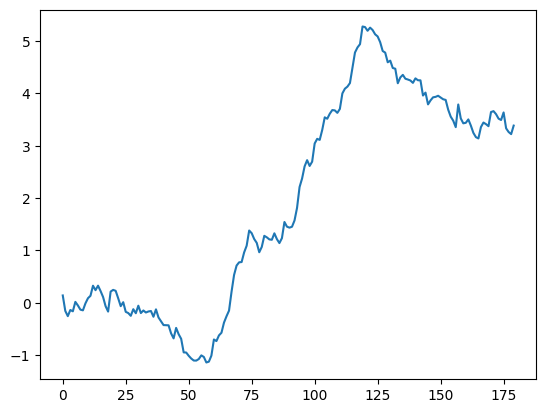

In [49]:
resize_flexevents_chisqz = np.array([
    resize_arr((np.square(np.concatenate([x,y,z]))-1)/np.sqrt(2), target_size=180)
    for i,(x,y,z) in enumerate(zip(alltimeperiodbefore_compositez, allevents_compositez, alltimeperiodafter_compositez))
    if surviving_events[i][0] in events_with_flex_start_end ])

plt.plot(np.cumsum(np.sum(resize_flexevents_chisqz[:,:], axis=0)/
                   np.sqrt(resize_flexevents_chisqz.shape[0]))/np.sqrt(60) )

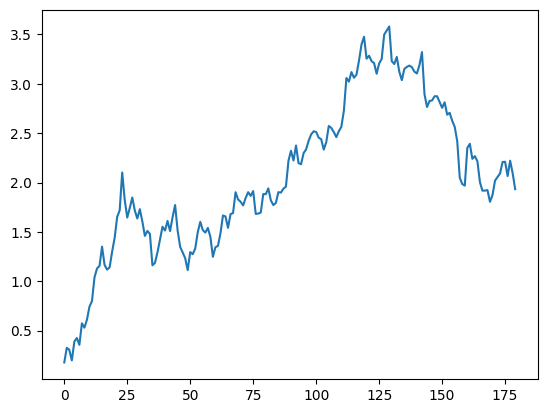

In [50]:
resize_nonflexevents_chisqz = np.array([
    resize_arr((np.square(np.concatenate([x,y,z]))-1)/np.sqrt(2), target_size=180)
    for i,(x,y,z) in enumerate(zip(alltimeperiodbefore_compositez, allevents_compositez, alltimeperiodafter_compositez))
    if surviving_events[i][0] not in events_with_flex_start_end ])

plt.plot(np.cumsum(np.sum(resize_nonflexevents_chisqz[:,:], axis=0)/
                   np.sqrt(resize_nonflexevents_chisqz.shape[0]))/np.sqrt(60) )